In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels, **kwargs),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.feature(x)
        return out

In [8]:
class InceptionA(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2, temp_channels3, out_channels3, out_channels4):
        super(InceptionA, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding=0, bias=False)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=5, stride=1, padding=2, bias=False),
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=3, stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels3, out_channels=out_channels3,
                        kernel_size=3, stride=1, padding=1, bias=False),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=out_channels4,
                        kernel_size=1, padding=0, bias=False),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

In [9]:
class InceptionB(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2):
        super(InceptionB, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=3, stride=2, padding=0, bias=False)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=3, stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=3, stride=2, padding=0, bias=False),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out

In [10]:
class InceptionC(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2, temp_channels3, out_channels3, out_channels4):
        super(InceptionC, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding=0, bias=False)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=temp_channels2,
                        kernel_size=(1, 7), stride=1, padding=(0, 3), bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=(7, 1), stride=1, padding=(3, 0), bias=False),
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(7, 1), stride=1, padding=(3, 0), bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(1, 7), stride=1, padding=(0, 3), bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(7, 1), stride=1, padding=(3, 0), bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=(1, 7), stride=1, padding=(0, 3), bias=False),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=out_channels4,
                        kernel_size=1, padding=0, bias=False),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

In [11]:
class InceptionD(nn.Module):
    def __init__(self, in_channels, temp_channels1, out_channels1, out_channels2):
        super(InceptionD, self).__init__()
        self.branch1 = nn.Sequential(
            BasicConv2d(
                in_channels=in_channels, out_channels=temp_channels1, kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(
                in_channels=temp_channels1, out_channels=out_channels1, kernel_size=3, stride=2, padding=0, bias=False)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=out_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=(1, 7), stride=1, padding=(0, 3), bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=(7, 1), stride=1, padding=(3, 0), bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=3, stride=2, padding=0, bias=False),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out

In [12]:
class InceptionE(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2, temp_channels3, out_channels3, out_channels4):
        super(InceptionE, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding=0, bias=False)
        self.branch2_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=temp_channels2,
                        kernel_size=(1, 3), stride=1, padding=(0, 1), bias=False),
        )
        self.branch2_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=(3, 1), stride=1, padding=(1, 0), bias=False),
        )
        self.branch3_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(3, 3), stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=(1, 3), stride=1, padding=(0, 1), bias=False),
        )
        self.branch3_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(3, 3), stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=(3, 1), stride=1, padding=(1, 0), bias=False),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=out_channels4,
                        kernel_size=1, padding=0, bias=False),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2_1 = self.branch2_1(x)
        out2_2 = self.branch2_2(x)
        out3_1 = self.branch3_1(x)
        out3_2 = self.branch3_2(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2_1, out2_2, out3_1, out3_2, out4], dim=1)
        return out

In [13]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionAux, self).__init__()
        self.auxiliary_avgpool = nn.AvgPool2d(
            kernel_size=3, stride=1, padding=1)
        self.auxiliary_conv1 = BasicConv2d(
            in_channels=in_channels, out_channels=128, kernel_size=1, padding=0, bias=False)
        self.auxiliary_conv2 = BasicConv2d(
            in_channels=128, out_channels=in_channels, kernel_size=5, padding=0, bias=False)
        self.auxiliary_dropout = nn.Dropout(p=0.5)
        self.auxiliary_linear1 = nn.Linear(
            in_features=in_channels, out_features=out_channels)

    def forward(self, x):
        x = self.auxiliary_conv1(self.auxiliary_avgpool(x))
        x = self.auxiliary_conv2(x)
        x = x.view(x.size(0), -1)
        out = self.auxiliary_linear1(self.auxiliary_dropout(x))
        return out

In [14]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=10, stage='non_train'):
        super(InceptionV3, self).__init__()
        self.stage = stage
        # input [batch,3,224,224] -> [batch,192,56,56]
        self.block1 = nn.Sequential(
            BasicConv2d(in_channels=3, out_channels=32,
                        kernel_size=3, stride=2, padding=0, bias=False),
            BasicConv2d(in_channels=32, out_channels=32,
                        kernel_size=3, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=32, out_channels=64,
                        kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            BasicConv2d(in_channels=64, out_channels=80,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=80, out_channels=192,
                        kernel_size=3, stride=1, padding=0, bias=False),
        )
        # input [batch,64,56,56] -> [batch,192,28,28]
        self.block2 = nn.Sequential(
            InceptionA(in_channels=192, out_channels1=64, temp_channels2=48,
                       out_channels2=64, temp_channels3=64, out_channels3=96, out_channels4=32),
            InceptionA(in_channels=256, out_channels1=64, temp_channels2=48,
                       out_channels2=64, temp_channels3=64, out_channels3=96, out_channels4=64),
            InceptionA(in_channels=288, out_channels1=64, temp_channels2=48,
                       out_channels2=64, temp_channels3=64, out_channels3=96, out_channels4=64),
        )
        # input[batch, 192, 28, 28] -> [batch, 480, 14, 14]
        self.block3 = InceptionB(
            in_channels=288, out_channels1=384, temp_channels2=64, out_channels2=96)
        # input [batch,480,14,14] -> [batch,832,7,7]
        self.block4 = nn.Sequential(
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=128,
                       out_channels2=192, temp_channels3=128, out_channels3=192, out_channels4=192),
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=160,
                       out_channels2=192, temp_channels3=160, out_channels3=192, out_channels4=192),
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=160,
                       out_channels2=192, temp_channels3=160, out_channels3=192, out_channels4=192),
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=192,
                       out_channels2=192, temp_channels3=192, out_channels3=192, out_channels4=192),
        )
        if self.stage == 'train':
            self.AuxLogits = InceptionAux(
                in_channels=768, out_channels=num_classes)
        else:
            self.AuxLogits = nn.Sequential()
        # input [batch,832,7,7] -> [batch,1024,7,7]
        self.block5 = InceptionD(
            in_channels=768, temp_channels1=192, out_channels1=320, out_channels2=192)
        self.block6 = nn.Sequential(
            InceptionE(in_channels=1280, out_channels1=320, temp_channels2=384,
                       out_channels2=384, temp_channels3=448, out_channels3=384, out_channels4=192),
            InceptionE(in_channels=2048, out_channels1=320, temp_channels2=384,
                       out_channels2=384, temp_channels3=448, out_channels3=384, out_channels4=192),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(
            in_features=2048, out_features=num_classes, bias=True)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        aux = self.AuxLogits(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        if self.stage == 'train':
            aux = self.aux_logits(aux)
            return aux, out
        else:
            return out

In [15]:
net = InceptionV3().to(DEVICE)
# net = models.inception_v3().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-7, factor=0.1, patience=3)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [18]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [19]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [20]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [21]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [22]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [23]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.335745
Train Epoch: 1 [3200/40000 (8%)]	Loss: 2.339338
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.790754
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.716074
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.837329
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.741076
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.620486
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.748507
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.581051
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.657903
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.377671
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.569035
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.370920
VAL set: Average loss: 0.043288, Accuracy: 5043.0/10000 (50.4%)
Validation loss decreased (inf --> 0.043288).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.262770
Train Epoch: 2 [3200/40000 (8%)]	Loss: 2.053280
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.628843
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.541410
Train Epoch: 2 [12800/40000 (32%)]	Loss

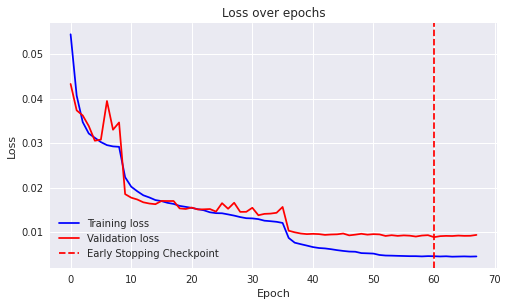

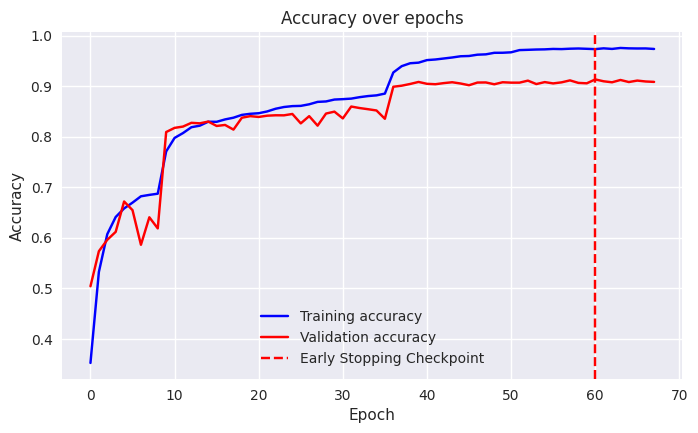

In [24]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'InceptionV3 - predictions')

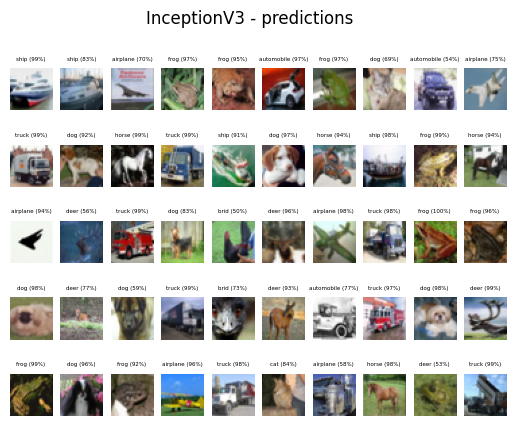

In [25]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('InceptionV3 - predictions')

In [ ]:
"""
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80, 54, 54]           5,120
      BatchNorm2d-15           [-1, 80, 54, 54]             160
             ReLU-16           [-1, 80, 54, 54]               0
      BasicConv2d-17           [-1, 80, 54, 54]               0
           Conv2d-18          [-1, 192, 52, 52]         138,240
      BatchNorm2d-19          [-1, 192, 52, 52]             384
             ReLU-20          [-1, 192, 52, 52]               0
      BasicConv2d-21          [-1, 192, 52, 52]               0
           Conv2d-22           [-1, 64, 52, 52]          12,288
      BatchNorm2d-23           [-1, 64, 52, 52]             128
             ReLU-24           [-1, 64, 52, 52]               0
      BasicConv2d-25           [-1, 64, 52, 52]               0
           Conv2d-26           [-1, 48, 52, 52]           9,216
      BatchNorm2d-27           [-1, 48, 52, 52]              96
             ReLU-28           [-1, 48, 52, 52]               0
      BasicConv2d-29           [-1, 48, 52, 52]               0
           Conv2d-30           [-1, 64, 52, 52]          76,800
      BatchNorm2d-31           [-1, 64, 52, 52]             128
             ReLU-32           [-1, 64, 52, 52]               0
      BasicConv2d-33           [-1, 64, 52, 52]               0
           Conv2d-34           [-1, 64, 52, 52]          12,288
      BatchNorm2d-35           [-1, 64, 52, 52]             128
             ReLU-36           [-1, 64, 52, 52]               0
      BasicConv2d-37           [-1, 64, 52, 52]               0
           Conv2d-38           [-1, 96, 52, 52]          55,296
      BatchNorm2d-39           [-1, 96, 52, 52]             192
             ReLU-40           [-1, 96, 52, 52]               0
      BasicConv2d-41           [-1, 96, 52, 52]               0
           Conv2d-42           [-1, 96, 52, 52]          82,944
      BatchNorm2d-43           [-1, 96, 52, 52]             192
             ReLU-44           [-1, 96, 52, 52]               0
      BasicConv2d-45           [-1, 96, 52, 52]               0
        MaxPool2d-46          [-1, 192, 52, 52]               0
           Conv2d-47           [-1, 32, 52, 52]           6,144
      BatchNorm2d-48           [-1, 32, 52, 52]              64
             ReLU-49           [-1, 32, 52, 52]               0
      BasicConv2d-50           [-1, 32, 52, 52]               0
       InceptionA-51          [-1, 256, 52, 52]               0
           Conv2d-52           [-1, 64, 52, 52]          16,384
      BatchNorm2d-53           [-1, 64, 52, 52]             128
             ReLU-54           [-1, 64, 52, 52]               0
      BasicConv2d-55           [-1, 64, 52, 52]               0
           Conv2d-56           [-1, 48, 52, 52]          12,288
      BatchNorm2d-57           [-1, 48, 52, 52]              96
             ReLU-58           [-1, 48, 52, 52]               0
      BasicConv2d-59           [-1, 48, 52, 52]               0
           Conv2d-60           [-1, 64, 52, 52]          76,800
      BatchNorm2d-61           [-1, 64, 52, 52]             128
             ReLU-62           [-1, 64, 52, 52]               0
      BasicConv2d-63           [-1, 64, 52, 52]               0
           Conv2d-64           [-1, 64, 52, 52]          16,384
      BatchNorm2d-65           [-1, 64, 52, 52]             128
             ReLU-66           [-1, 64, 52, 52]               0
      BasicConv2d-67           [-1, 64, 52, 52]               0
           Conv2d-68           [-1, 96, 52, 52]          55,296
      BatchNorm2d-69           [-1, 96, 52, 52]             192
             ReLU-70           [-1, 96, 52, 52]               0
      BasicConv2d-71           [-1, 96, 52, 52]               0
           Conv2d-72           [-1, 96, 52, 52]          82,944
      BatchNorm2d-73           [-1, 96, 52, 52]             192
             ReLU-74           [-1, 96, 52, 52]               0
      BasicConv2d-75           [-1, 96, 52, 52]               0
        MaxPool2d-76          [-1, 256, 52, 52]               0
           Conv2d-77           [-1, 64, 52, 52]          16,384
      BatchNorm2d-78           [-1, 64, 52, 52]             128
             ReLU-79           [-1, 64, 52, 52]               0
      BasicConv2d-80           [-1, 64, 52, 52]               0
       InceptionA-81          [-1, 288, 52, 52]               0
           Conv2d-82           [-1, 64, 52, 52]          18,432
      BatchNorm2d-83           [-1, 64, 52, 52]             128
             ReLU-84           [-1, 64, 52, 52]               0
      BasicConv2d-85           [-1, 64, 52, 52]               0
           Conv2d-86           [-1, 48, 52, 52]          13,824
      BatchNorm2d-87           [-1, 48, 52, 52]              96
             ReLU-88           [-1, 48, 52, 52]               0
      BasicConv2d-89           [-1, 48, 52, 52]               0
           Conv2d-90           [-1, 64, 52, 52]          76,800
      BatchNorm2d-91           [-1, 64, 52, 52]             128
             ReLU-92           [-1, 64, 52, 52]               0
      BasicConv2d-93           [-1, 64, 52, 52]               0
           Conv2d-94           [-1, 64, 52, 52]          18,432
      BatchNorm2d-95           [-1, 64, 52, 52]             128
             ReLU-96           [-1, 64, 52, 52]               0
      BasicConv2d-97           [-1, 64, 52, 52]               0
           Conv2d-98           [-1, 96, 52, 52]          55,296
      BatchNorm2d-99           [-1, 96, 52, 52]             192
            ReLU-100           [-1, 96, 52, 52]               0
     BasicConv2d-101           [-1, 96, 52, 52]               0
          Conv2d-102           [-1, 96, 52, 52]          82,944
     BatchNorm2d-103           [-1, 96, 52, 52]             192
            ReLU-104           [-1, 96, 52, 52]               0
     BasicConv2d-105           [-1, 96, 52, 52]               0
       MaxPool2d-106          [-1, 288, 52, 52]               0
          Conv2d-107           [-1, 64, 52, 52]          18,432
     BatchNorm2d-108           [-1, 64, 52, 52]             128
            ReLU-109           [-1, 64, 52, 52]               0
     BasicConv2d-110           [-1, 64, 52, 52]               0
      InceptionA-111          [-1, 288, 52, 52]               0
          Conv2d-112          [-1, 384, 25, 25]         995,328
     BatchNorm2d-113          [-1, 384, 25, 25]             768
            ReLU-114          [-1, 384, 25, 25]               0
     BasicConv2d-115          [-1, 384, 25, 25]               0
          Conv2d-116           [-1, 64, 52, 52]          18,432
     BatchNorm2d-117           [-1, 64, 52, 52]             128
            ReLU-118           [-1, 64, 52, 52]               0
     BasicConv2d-119           [-1, 64, 52, 52]               0
          Conv2d-120           [-1, 96, 52, 52]          55,296
     BatchNorm2d-121           [-1, 96, 52, 52]             192
            ReLU-122           [-1, 96, 52, 52]               0
     BasicConv2d-123           [-1, 96, 52, 52]               0
          Conv2d-124           [-1, 96, 25, 25]          82,944
     BatchNorm2d-125           [-1, 96, 25, 25]             192
            ReLU-126           [-1, 96, 25, 25]               0
     BasicConv2d-127           [-1, 96, 25, 25]               0
       MaxPool2d-128          [-1, 288, 25, 25]               0
     BatchNorm2d-129          [-1, 288, 25, 25]             576
            ReLU-130          [-1, 288, 25, 25]               0
      InceptionB-131          [-1, 768, 25, 25]               0
          Conv2d-132          [-1, 192, 25, 25]         147,456
     BatchNorm2d-133          [-1, 192, 25, 25]             384
            ReLU-134          [-1, 192, 25, 25]               0
     BasicConv2d-135          [-1, 192, 25, 25]               0
          Conv2d-136          [-1, 128, 25, 25]          98,304
     BatchNorm2d-137          [-1, 128, 25, 25]             256
            ReLU-138          [-1, 128, 25, 25]               0
     BasicConv2d-139          [-1, 128, 25, 25]               0
          Conv2d-140          [-1, 128, 25, 25]         114,688
     BatchNorm2d-141          [-1, 128, 25, 25]             256
            ReLU-142          [-1, 128, 25, 25]               0
     BasicConv2d-143          [-1, 128, 25, 25]               0
          Conv2d-144          [-1, 192, 25, 25]         172,032
     BatchNorm2d-145          [-1, 192, 25, 25]             384
            ReLU-146          [-1, 192, 25, 25]               0
     BasicConv2d-147          [-1, 192, 25, 25]               0
          Conv2d-148          [-1, 128, 25, 25]          98,304
     BatchNorm2d-149          [-1, 128, 25, 25]             256
            ReLU-150          [-1, 128, 25, 25]               0
     BasicConv2d-151          [-1, 128, 25, 25]               0
          Conv2d-152          [-1, 128, 25, 25]         114,688
     BatchNorm2d-153          [-1, 128, 25, 25]             256
            ReLU-154          [-1, 128, 25, 25]               0
     BasicConv2d-155          [-1, 128, 25, 25]               0
          Conv2d-156          [-1, 128, 25, 25]         114,688
     BatchNorm2d-157          [-1, 128, 25, 25]             256
            ReLU-158          [-1, 128, 25, 25]               0
     BasicConv2d-159          [-1, 128, 25, 25]               0
          Conv2d-160          [-1, 128, 25, 25]         114,688
     BatchNorm2d-161          [-1, 128, 25, 25]             256
            ReLU-162          [-1, 128, 25, 25]               0
     BasicConv2d-163          [-1, 128, 25, 25]               0
          Conv2d-164          [-1, 192, 25, 25]         172,032
     BatchNorm2d-165          [-1, 192, 25, 25]             384
            ReLU-166          [-1, 192, 25, 25]               0
     BasicConv2d-167          [-1, 192, 25, 25]               0
       MaxPool2d-168          [-1, 768, 25, 25]               0
          Conv2d-169          [-1, 192, 25, 25]         147,456
     BatchNorm2d-170          [-1, 192, 25, 25]             384
            ReLU-171          [-1, 192, 25, 25]               0
     BasicConv2d-172          [-1, 192, 25, 25]               0
      InceptionC-173          [-1, 768, 25, 25]               0
          Conv2d-174          [-1, 192, 25, 25]         147,456
     BatchNorm2d-175          [-1, 192, 25, 25]             384
            ReLU-176          [-1, 192, 25, 25]               0
     BasicConv2d-177          [-1, 192, 25, 25]               0
          Conv2d-178          [-1, 160, 25, 25]         122,880
     BatchNorm2d-179          [-1, 160, 25, 25]             320
            ReLU-180          [-1, 160, 25, 25]               0
     BasicConv2d-181          [-1, 160, 25, 25]               0
          Conv2d-182          [-1, 160, 25, 25]         179,200
     BatchNorm2d-183          [-1, 160, 25, 25]             320
            ReLU-184          [-1, 160, 25, 25]               0
     BasicConv2d-185          [-1, 160, 25, 25]               0
          Conv2d-186          [-1, 192, 25, 25]         215,040
     BatchNorm2d-187          [-1, 192, 25, 25]             384
            ReLU-188          [-1, 192, 25, 25]               0
     BasicConv2d-189          [-1, 192, 25, 25]               0
          Conv2d-190          [-1, 160, 25, 25]         122,880
     BatchNorm2d-191          [-1, 160, 25, 25]             320
            ReLU-192          [-1, 160, 25, 25]               0
     BasicConv2d-193          [-1, 160, 25, 25]               0
          Conv2d-194          [-1, 160, 25, 25]         179,200
     BatchNorm2d-195          [-1, 160, 25, 25]             320
            ReLU-196          [-1, 160, 25, 25]               0
     BasicConv2d-197          [-1, 160, 25, 25]               0
          Conv2d-198          [-1, 160, 25, 25]         179,200
     BatchNorm2d-199          [-1, 160, 25, 25]             320
            ReLU-200          [-1, 160, 25, 25]               0
     BasicConv2d-201          [-1, 160, 25, 25]               0
          Conv2d-202          [-1, 160, 25, 25]         179,200
     BatchNorm2d-203          [-1, 160, 25, 25]             320
            ReLU-204          [-1, 160, 25, 25]               0
     BasicConv2d-205          [-1, 160, 25, 25]               0
          Conv2d-206          [-1, 192, 25, 25]         215,040
     BatchNorm2d-207          [-1, 192, 25, 25]             384
            ReLU-208          [-1, 192, 25, 25]               0
     BasicConv2d-209          [-1, 192, 25, 25]               0
       MaxPool2d-210          [-1, 768, 25, 25]               0
          Conv2d-211          [-1, 192, 25, 25]         147,456
     BatchNorm2d-212          [-1, 192, 25, 25]             384
            ReLU-213          [-1, 192, 25, 25]               0
     BasicConv2d-214          [-1, 192, 25, 25]               0
      InceptionC-215          [-1, 768, 25, 25]               0
          Conv2d-216          [-1, 192, 25, 25]         147,456
     BatchNorm2d-217          [-1, 192, 25, 25]             384
            ReLU-218          [-1, 192, 25, 25]               0
     BasicConv2d-219          [-1, 192, 25, 25]               0
          Conv2d-220          [-1, 160, 25, 25]         122,880
     BatchNorm2d-221          [-1, 160, 25, 25]             320
            ReLU-222          [-1, 160, 25, 25]               0
     BasicConv2d-223          [-1, 160, 25, 25]               0
          Conv2d-224          [-1, 160, 25, 25]         179,200
     BatchNorm2d-225          [-1, 160, 25, 25]             320
            ReLU-226          [-1, 160, 25, 25]               0
     BasicConv2d-227          [-1, 160, 25, 25]               0
          Conv2d-228          [-1, 192, 25, 25]         215,040
     BatchNorm2d-229          [-1, 192, 25, 25]             384
            ReLU-230          [-1, 192, 25, 25]               0
     BasicConv2d-231          [-1, 192, 25, 25]               0
          Conv2d-232          [-1, 160, 25, 25]         122,880
     BatchNorm2d-233          [-1, 160, 25, 25]             320
            ReLU-234          [-1, 160, 25, 25]               0
     BasicConv2d-235          [-1, 160, 25, 25]               0
          Conv2d-236          [-1, 160, 25, 25]         179,200
     BatchNorm2d-237          [-1, 160, 25, 25]             320
            ReLU-238          [-1, 160, 25, 25]               0
     BasicConv2d-239          [-1, 160, 25, 25]               0
          Conv2d-240          [-1, 160, 25, 25]         179,200
     BatchNorm2d-241          [-1, 160, 25, 25]             320
            ReLU-242          [-1, 160, 25, 25]               0
     BasicConv2d-243          [-1, 160, 25, 25]               0
          Conv2d-244          [-1, 160, 25, 25]         179,200
     BatchNorm2d-245          [-1, 160, 25, 25]             320
            ReLU-246          [-1, 160, 25, 25]               0
     BasicConv2d-247          [-1, 160, 25, 25]               0
          Conv2d-248          [-1, 192, 25, 25]         215,040
     BatchNorm2d-249          [-1, 192, 25, 25]             384
            ReLU-250          [-1, 192, 25, 25]               0
     BasicConv2d-251          [-1, 192, 25, 25]               0
       MaxPool2d-252          [-1, 768, 25, 25]               0
          Conv2d-253          [-1, 192, 25, 25]         147,456
     BatchNorm2d-254          [-1, 192, 25, 25]             384
            ReLU-255          [-1, 192, 25, 25]               0
     BasicConv2d-256          [-1, 192, 25, 25]               0
      InceptionC-257          [-1, 768, 25, 25]               0
          Conv2d-258          [-1, 192, 25, 25]         147,456
     BatchNorm2d-259          [-1, 192, 25, 25]             384
            ReLU-260          [-1, 192, 25, 25]               0
     BasicConv2d-261          [-1, 192, 25, 25]               0
          Conv2d-262          [-1, 192, 25, 25]         147,456
     BatchNorm2d-263          [-1, 192, 25, 25]             384
            ReLU-264          [-1, 192, 25, 25]               0
     BasicConv2d-265          [-1, 192, 25, 25]               0
          Conv2d-266          [-1, 192, 25, 25]         258,048
     BatchNorm2d-267          [-1, 192, 25, 25]             384
            ReLU-268          [-1, 192, 25, 25]               0
     BasicConv2d-269          [-1, 192, 25, 25]               0
          Conv2d-270          [-1, 192, 25, 25]         258,048
     BatchNorm2d-271          [-1, 192, 25, 25]             384
            ReLU-272          [-1, 192, 25, 25]               0
     BasicConv2d-273          [-1, 192, 25, 25]               0
          Conv2d-274          [-1, 192, 25, 25]         147,456
     BatchNorm2d-275          [-1, 192, 25, 25]             384
            ReLU-276          [-1, 192, 25, 25]               0
     BasicConv2d-277          [-1, 192, 25, 25]               0
          Conv2d-278          [-1, 192, 25, 25]         258,048
     BatchNorm2d-279          [-1, 192, 25, 25]             384
            ReLU-280          [-1, 192, 25, 25]               0
     BasicConv2d-281          [-1, 192, 25, 25]               0
          Conv2d-282          [-1, 192, 25, 25]         258,048
     BatchNorm2d-283          [-1, 192, 25, 25]             384
            ReLU-284          [-1, 192, 25, 25]               0
     BasicConv2d-285          [-1, 192, 25, 25]               0
          Conv2d-286          [-1, 192, 25, 25]         258,048
     BatchNorm2d-287          [-1, 192, 25, 25]             384
            ReLU-288          [-1, 192, 25, 25]               0
     BasicConv2d-289          [-1, 192, 25, 25]               0
          Conv2d-290          [-1, 192, 25, 25]         258,048
     BatchNorm2d-291          [-1, 192, 25, 25]             384
            ReLU-292          [-1, 192, 25, 25]               0
     BasicConv2d-293          [-1, 192, 25, 25]               0
       MaxPool2d-294          [-1, 768, 25, 25]               0
          Conv2d-295          [-1, 192, 25, 25]         147,456
     BatchNorm2d-296          [-1, 192, 25, 25]             384
            ReLU-297          [-1, 192, 25, 25]               0
     BasicConv2d-298          [-1, 192, 25, 25]               0
      InceptionC-299          [-1, 768, 25, 25]               0
          Conv2d-300          [-1, 192, 25, 25]         147,456
     BatchNorm2d-301          [-1, 192, 25, 25]             384
            ReLU-302          [-1, 192, 25, 25]               0
     BasicConv2d-303          [-1, 192, 25, 25]               0
          Conv2d-304          [-1, 320, 12, 12]         552,960
     BatchNorm2d-305          [-1, 320, 12, 12]             640
            ReLU-306          [-1, 320, 12, 12]               0
     BasicConv2d-307          [-1, 320, 12, 12]               0
          Conv2d-308          [-1, 192, 25, 25]         147,456
     BatchNorm2d-309          [-1, 192, 25, 25]             384
            ReLU-310          [-1, 192, 25, 25]               0
     BasicConv2d-311          [-1, 192, 25, 25]               0
          Conv2d-312          [-1, 192, 25, 25]         258,048
     BatchNorm2d-313          [-1, 192, 25, 25]             384
            ReLU-314          [-1, 192, 25, 25]               0
     BasicConv2d-315          [-1, 192, 25, 25]               0
          Conv2d-316          [-1, 192, 25, 25]         258,048
     BatchNorm2d-317          [-1, 192, 25, 25]             384
            ReLU-318          [-1, 192, 25, 25]               0
     BasicConv2d-319          [-1, 192, 25, 25]               0
          Conv2d-320          [-1, 192, 12, 12]         331,776
     BatchNorm2d-321          [-1, 192, 12, 12]             384
            ReLU-322          [-1, 192, 12, 12]               0
     BasicConv2d-323          [-1, 192, 12, 12]               0
       MaxPool2d-324          [-1, 768, 12, 12]               0
     BatchNorm2d-325          [-1, 768, 12, 12]           1,536
            ReLU-326          [-1, 768, 12, 12]               0
      InceptionD-327         [-1, 1280, 12, 12]               0
          Conv2d-328          [-1, 320, 12, 12]         409,600
     BatchNorm2d-329          [-1, 320, 12, 12]             640
            ReLU-330          [-1, 320, 12, 12]               0
     BasicConv2d-331          [-1, 320, 12, 12]               0
          Conv2d-332          [-1, 384, 12, 12]         491,520
     BatchNorm2d-333          [-1, 384, 12, 12]             768
            ReLU-334          [-1, 384, 12, 12]               0
     BasicConv2d-335          [-1, 384, 12, 12]               0
          Conv2d-336          [-1, 384, 12, 12]         442,368
     BatchNorm2d-337          [-1, 384, 12, 12]             768
            ReLU-338          [-1, 384, 12, 12]               0
     BasicConv2d-339          [-1, 384, 12, 12]               0
          Conv2d-340          [-1, 384, 12, 12]         491,520
     BatchNorm2d-341          [-1, 384, 12, 12]             768
            ReLU-342          [-1, 384, 12, 12]               0
     BasicConv2d-343          [-1, 384, 12, 12]               0
          Conv2d-344          [-1, 384, 12, 12]         442,368
     BatchNorm2d-345          [-1, 384, 12, 12]             768
            ReLU-346          [-1, 384, 12, 12]               0
     BasicConv2d-347          [-1, 384, 12, 12]               0
          Conv2d-348          [-1, 448, 12, 12]         573,440
     BatchNorm2d-349          [-1, 448, 12, 12]             896
            ReLU-350          [-1, 448, 12, 12]               0
     BasicConv2d-351          [-1, 448, 12, 12]               0
          Conv2d-352          [-1, 448, 12, 12]       1,806,336
     BatchNorm2d-353          [-1, 448, 12, 12]             896
            ReLU-354          [-1, 448, 12, 12]               0
     BasicConv2d-355          [-1, 448, 12, 12]               0
          Conv2d-356          [-1, 384, 12, 12]         516,096
     BatchNorm2d-357          [-1, 384, 12, 12]             768
            ReLU-358          [-1, 384, 12, 12]               0
     BasicConv2d-359          [-1, 384, 12, 12]               0
          Conv2d-360          [-1, 448, 12, 12]         573,440
     BatchNorm2d-361          [-1, 448, 12, 12]             896
            ReLU-362          [-1, 448, 12, 12]               0
     BasicConv2d-363          [-1, 448, 12, 12]               0
          Conv2d-364          [-1, 448, 12, 12]       1,806,336
     BatchNorm2d-365          [-1, 448, 12, 12]             896
            ReLU-366          [-1, 448, 12, 12]               0
     BasicConv2d-367          [-1, 448, 12, 12]               0
          Conv2d-368          [-1, 384, 12, 12]         516,096
     BatchNorm2d-369          [-1, 384, 12, 12]             768
            ReLU-370          [-1, 384, 12, 12]               0
     BasicConv2d-371          [-1, 384, 12, 12]               0
       MaxPool2d-372         [-1, 1280, 12, 12]               0
          Conv2d-373          [-1, 192, 12, 12]         245,760
     BatchNorm2d-374          [-1, 192, 12, 12]             384
            ReLU-375          [-1, 192, 12, 12]               0
     BasicConv2d-376          [-1, 192, 12, 12]               0
      InceptionE-377         [-1, 2048, 12, 12]               0
          Conv2d-378          [-1, 320, 12, 12]         655,360
     BatchNorm2d-379          [-1, 320, 12, 12]             640
            ReLU-380          [-1, 320, 12, 12]               0
     BasicConv2d-381          [-1, 320, 12, 12]               0
          Conv2d-382          [-1, 384, 12, 12]         786,432
     BatchNorm2d-383          [-1, 384, 12, 12]             768
            ReLU-384          [-1, 384, 12, 12]               0
     BasicConv2d-385          [-1, 384, 12, 12]               0
          Conv2d-386          [-1, 384, 12, 12]         442,368
     BatchNorm2d-387          [-1, 384, 12, 12]             768
            ReLU-388          [-1, 384, 12, 12]               0
     BasicConv2d-389          [-1, 384, 12, 12]               0
          Conv2d-390          [-1, 384, 12, 12]         786,432
     BatchNorm2d-391          [-1, 384, 12, 12]             768
            ReLU-392          [-1, 384, 12, 12]               0
     BasicConv2d-393          [-1, 384, 12, 12]               0
          Conv2d-394          [-1, 384, 12, 12]         442,368
     BatchNorm2d-395          [-1, 384, 12, 12]             768
            ReLU-396          [-1, 384, 12, 12]               0
     BasicConv2d-397          [-1, 384, 12, 12]               0
          Conv2d-398          [-1, 448, 12, 12]         917,504
     BatchNorm2d-399          [-1, 448, 12, 12]             896
            ReLU-400          [-1, 448, 12, 12]               0
     BasicConv2d-401          [-1, 448, 12, 12]               0
          Conv2d-402          [-1, 448, 12, 12]       1,806,336
     BatchNorm2d-403          [-1, 448, 12, 12]             896
            ReLU-404          [-1, 448, 12, 12]               0
     BasicConv2d-405          [-1, 448, 12, 12]               0
          Conv2d-406          [-1, 384, 12, 12]         516,096
     BatchNorm2d-407          [-1, 384, 12, 12]             768
            ReLU-408          [-1, 384, 12, 12]               0
     BasicConv2d-409          [-1, 384, 12, 12]               0
          Conv2d-410          [-1, 448, 12, 12]         917,504
     BatchNorm2d-411          [-1, 448, 12, 12]             896
            ReLU-412          [-1, 448, 12, 12]               0
     BasicConv2d-413          [-1, 448, 12, 12]               0
          Conv2d-414          [-1, 448, 12, 12]       1,806,336
     BatchNorm2d-415          [-1, 448, 12, 12]             896
            ReLU-416          [-1, 448, 12, 12]               0
     BasicConv2d-417          [-1, 448, 12, 12]               0
          Conv2d-418          [-1, 384, 12, 12]         516,096
     BatchNorm2d-419          [-1, 384, 12, 12]             768
            ReLU-420          [-1, 384, 12, 12]               0
     BasicConv2d-421          [-1, 384, 12, 12]               0
       MaxPool2d-422         [-1, 2048, 12, 12]               0
          Conv2d-423          [-1, 192, 12, 12]         393,216
     BatchNorm2d-424          [-1, 192, 12, 12]             384
            ReLU-425          [-1, 192, 12, 12]               0
     BasicConv2d-426          [-1, 192, 12, 12]               0
      InceptionE-427         [-1, 2048, 12, 12]               0
AdaptiveAvgPool2d-428           [-1, 2048, 1, 1]               0
         Dropout-429                 [-1, 2048]               0
          Linear-430                   [-1, 10]          20,490
================================================================
Total params: 29,006,122
Trainable params: 29,006,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 484.52
Params size (MB): 110.65
Estimated Total Size (MB): 595.74
----------------------------------------------------------------
parameters_count: 29006122
"""